In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import Tensor
from torchsummary import summary
import random
from numpy import load
from tqdm import tqdm, trange
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import pickle
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
%run './Attention_based_model.ipynb'

Sat Jul 13 13:56:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4080        Off | 00000000:01:00.0  On |                  N/A |
|  0%   34C    P8               6W / 320W |    550MiB / 16376MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# check the availability of cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")
with open('CIC2018-dataset-all-new.pkl', 'rb') as f:
    train_data = pickle.load(f)
train_loader = DataLoader(train_data, batch_size=8, shuffle=True, pin_memory=True)

Using device:  cuda (NVIDIA GeForce RTX 4080)


In [3]:
data_points = []
labels = []

with torch.no_grad():
    # progress bar
    data_iter = tqdm.tqdm(
        enumerate(train_loader),
        total=len(train_loader),
        bar_format="{l_bar}{r_bar}"
    )
    for i, data in data_iter:  # Assuming you have an inference data loader
        data = {key: value.to(device) for key, value in data.items()}
        inputs, label = data["netformer_input"], data["sequence_label"]
        
        inputs = inputs.cpu().numpy()
        label = label.cpu().numpy()
        
        # Collect the data points and labels
        for j in range(inputs.shape[0]):
            data_points.append(inputs[j])
            labels.append(label[j])

# Convert lists to numpy arrays
data_points_np = np.array(data_points)
labels_np = np.array(labels)

# Print shapes to verify
print('Data points shape:', data_points_np.shape)
print('Labels shape:', labels_np.shape)

print(Counter(labels_np))

100%|| 1281/1281 [00:03<00:00, 378.27it/s]

Data points shape: (10246, 2000)
Labels shape: (10246,)
Counter({0.0: 4715, 1.0: 4236, 2.0: 862, 4.0: 430, 3.0: 2, 5.0: 1})


In [4]:
# Select data points with class [0, 1, 2, 4]
selected_classes = [0, 1, 2, 4]
relabel_map = {0: 0, 1: 1, 2: 2, 4: 3}

selected_indices = np.where(np.isin(labels_np, selected_classes))[0]

selected_data = data_points_np[selected_indices]
selected_labels = labels_np[selected_indices]

# Relabel
for old_label, new_label in relabel_map.items():
    selected_labels[selected_labels == old_label] = new_label

# Ensure 125 examples for each class

sample_numeber_list = [110,120,130,150, 200, 250, 300, 400]
for sample in sample_numeber_list:
    final_data = []
    final_labels = []
    for class_label in relabel_map.values():
        class_indices = np.where(selected_labels == class_label)[0]
        chosen_indices = np.random.choice(class_indices, sample, replace=False)
        final_data.append(selected_data[chosen_indices])
        final_labels.append(selected_labels[chosen_indices])
    
    final_data = np.concatenate(final_data)
    final_labels = np.concatenate(final_labels)
    
    # Final data and labels shapes
    print("Final Data points shape:", final_data.shape)
    print("Final Labels shape:", final_labels.shape)
    print("Final Counter:", Counter(final_labels))

    data_points = final_data 
    labels = final_labels

    if len(labels) >= 100:
        test_size = 100
    else:
        test_size = len(labels) // 10
    
    # Data preprocessing
    scaler = StandardScaler()
    data_points = scaler.fit_transform(data_points)
    
    # Reshape data for LSTM model
    data_points = data_points.reshape((data_points.shape[0], 1, data_points.shape[1]))
    
    # Convert data to PyTorch tensors
    data_points = torch.tensor(data_points, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.long)  # Note: Changed to long for classification
    
    # # Split the data into training and test sets
    # X_train, X_test, y_train, y_test = train_test_split(data_points, labels, test_size=0.2, random_state=42)
    # print('training size : ', len(y_train))
    # print('testing size : ', len(y_test))
    # # Create DataLoader for batching
    # train_dataset = TensorDataset(X_train, y_train)
    # test_dataset = TensorDataset(X_test, y_test)
    
    # train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    # test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Splitting data into training and test sets per class
    test_indices = []
    train_indices = []
    
    # Ensure at least 100 samples per class for the test set
    for class_label in torch.unique(labels):
        class_indices = (labels == class_label).nonzero(as_tuple=True)[0]
        if len(class_indices) < 100:
            raise ValueError(f"Not enough samples for class {class_label} to allocate 100 samples to the test set.")
        test_indices_class = np.random.choice(class_indices, 100, replace=False)
        train_indices_class = np.setdiff1d(class_indices, test_indices_class)
    
        test_indices.extend(test_indices_class.tolist())  # Convert to list and extend
        train_indices.extend(train_indices_class.tolist())  # Convert to list and extend
    
    # Convert lists to numpy arrays for indexing
    test_indices = np.array(test_indices)
    train_indices = np.array(train_indices)
    
    # Create datasets
    X_test = data_points[test_indices]
    y_test = labels[test_indices]
    X_train = data_points[train_indices]
    y_train = labels[train_indices]


    print('training size : ', len(y_train))
    print('testing size : ', len(y_test))
    # Create DataLoader for batching
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    
    # Define the LSTM model
    class LSTMModel(nn.Module):
        def __init__(self):
            super(LSTMModel, self).__init__()
            self.lstm1 = nn.LSTM(input_size=2000, hidden_size=128, batch_first=True)
            self.lstm2 = nn.LSTM(input_size=128, hidden_size=64, batch_first=True)
            self.lstm3 = nn.LSTM(input_size=64, hidden_size=32, batch_first=True)
            self.fc = nn.Linear(32, 4)  # Output size changed to 4 for 4-class classification
            
        def forward(self, x):
            x, _ = self.lstm1(x)
            x, _ = self.lstm2(x)
            x, _ = self.lstm3(x)
            x = x[:, -1, :]
            x = self.fc(x)
            return x  # Removed sigmoid for multi-class classification
    
    # Instantiate the model, define the loss function and the optimizer
    model = LSTMModel()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training the model
    num_epochs = 40
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        # print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')
    
    # Evaluating the model
    model.eval()
    all_labels = []
    all_predictions = []
    all_probabilities = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)
    all_probabilities = np.array(all_probabilities)
    
    # Calculate metrics
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    # For multi-class, we use one-vs-rest strategy to calculate AUC
    auc = roc_auc_score(all_labels, all_probabilities, multi_class='ovr', average='weighted')
    
    print(f'Confusion Matrix:\n{conf_matrix}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'AUC: {auc:.4f}')
    print(classification_report(all_labels, all_predictions))




Final Data points shape: (440, 2000)
Final Labels shape: (440,)
Final Counter: Counter({0.0: 110, 1.0: 110, 2.0: 110, 3.0: 110})
training size :  40
testing size :  400
Confusion Matrix:
[[57 22 16  5]
 [ 0 71 10 19]
 [32 14 30 24]
 [18 22 30 30]]
Accuracy: 0.4700
Precision: 0.4541
Recall: 0.4700
F1 Score: 0.4576
AUC: 0.7542
              precision    recall  f1-score   support

           0       0.53      0.57      0.55       100
           1       0.55      0.71      0.62       100
           2       0.35      0.30      0.32       100
           3       0.38      0.30      0.34       100

    accuracy                           0.47       400
   macro avg       0.45      0.47      0.46       400
weighted avg       0.45      0.47      0.46       400

Final Data points shape: (480, 2000)
Final Labels shape: (480,)
Final Counter: Counter({0.0: 120, 1.0: 120, 2.0: 120, 3.0: 120})
training size :  80
testing size :  400
Confusion Matrix:
[[ 66  21   3  10]
 [  0 100   0   0]
 [ 30  12  42

In [6]:
import time 

# Evaluating the model
model.eval()
all_labels = []
all_predictions = []
all_probabilities = []

total_inference_time = 0  # Initialize total inference time

with torch.no_grad():
    for inputs, labels in test_loader:
        start_time = time.time()  # Record the start time
        outputs = model(inputs)
        end_time = time.time()  # Record the end time
        
        inference_time = end_time - start_time  # Calculate the inference time for the batch
        total_inference_time += inference_time  # Accumulate the total inference time

        probabilities = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        all_probabilities.extend(probabilities.cpu().numpy())

# Calculate the average inference time per data point
total_data_points = len(test_loader.dataset)
average_inference_time = total_inference_time / total_data_points

print(f'Average inference time per data point: {average_inference_time:.6f} seconds')

all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)
all_probabilities = np.array(all_probabilities)

# Calculate metrics
conf_matrix = confusion_matrix(all_labels, all_predictions)
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')
# For multi-class, we use one-vs-rest strategy to calculate AUC
auc = roc_auc_score(all_labels, all_probabilities, multi_class='ovr', average='weighted')

print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'AUC: {auc:.4f}')
print(classification_report(all_labels, all_predictions))

Average inference time per data point: 0.000040 seconds
Confusion Matrix:
[[ 81   9   7   3]
 [  0 100   0   0]
 [  0   0  99   1]
 [  0   1  23  76]]
Accuracy: 0.8900
Precision: 0.9066
Recall: 0.8900
F1 Score: 0.8891
AUC: 0.9851
              precision    recall  f1-score   support

           0       1.00      0.81      0.90       100
           1       0.91      1.00      0.95       100
           2       0.77      0.99      0.86       100
           3       0.95      0.76      0.84       100

    accuracy                           0.89       400
   macro avg       0.91      0.89      0.89       400
weighted avg       0.91      0.89      0.89       400



In [ ]:
accuracy_lstm_1 = [0.2600,0.6169,0.6894,0.7400,0.8331,0.8589,0.9344]
# Extracted accuracy from the provided data
accuracy_lstm_2 = [0.3333, 0.5500, 0.7600, 0.7000, 0.8400, 0.8500, 0.8719]

# Extracted accuracy from the provided data
accuracy_lstm_3 = [0.3333, 0.4500, 0.7600, 0.6400, 0.8400, 0.7958, 0.9156]

# Extracted accuracy from the provided data
accuracy_lstm_4 = [0.3333, 0.4500, 0.6200, 0.8400, 0.8750, 0.8583, 0.9031]
accuracy_lstm_5 = [0.5000, 0.6000, 0.6000, 0.7500, 0.8700, 0.8208, 0.9000]

f1_scores_LSTM_1 = {
    0: [0.33, 0.73, 0.82, 0.88, 0.84, 0.94, 0.93],
    1: [0.33, 0.91, 0.96, 0.94, 0.93, 0.97, 0.96],
    2: [0.00, 0.36, 0.40, 0.62, 0.81, 0.75, 0.94],
    3: [0.00, 0.29, 0.52, 0.55, 0.71, 0.63, 0.89]
}

f1_scores_LSTM_2 = {
    0: [0.50, 0.55, 0.80, 0.86, 0.90, 0.89, 0.89],
    1: [0.44, 0.71, 0.92, 0.86, 0.97, 0.93, 0.95],
    2: [0.00, 0.40, 0.70, 0.60, 0.80, 0.81, 0.83],
    3: [0.00, 0.40, 0.61, 0.51, 0.67, 0.75, 0.79]
}

# Extracted F1 scores for each class from the provided data
f1_scores_LSTM_3  = {
    0: [0.44, 0.62, 0.86, 0.73, 0.85, 0.88, 0.92],
    1: [0.50, 0.59, 0.85, 0.72, 0.89, 0.91, 0.95],
    2: [0.00, 0.00, 0.67, 0.54, 0.85, 0.74, 0.89],
    3: [0.00, 0.00, 0.64, 0.57, 0.75, 0.61, 0.89]
}


# Extracted F1 scores for each class from the provided data
f1_scores_LSTM_4 = {
    0: [0.50, 0.44, 0.74, 0.93, 0.93, 0.91, 0.92],
    1: [0.29, 0.63, 0.85, 0.91, 0.96, 0.95, 0.96],
    2: [0.00, 0.00, 0.57, 0.78, 0.84, 0.79, 0.87],
    3: [0.33, 0.22, 0.11, 0.76, 0.76, 0.77, 0.84]
}

f1_scores_LSTM_5  = {
    0: [0.57, 0.77, 0.72, 0.79, 0.94, 0.88, 0.93],
    1: [0.57, 0.80, 0.76, 0.83, 0.96, 0.94, 0.96],
    2: [0.40, 0.00, 0.52, 0.76, 0.82, 0.79, 0.86],
    3: [0.40, 0.25, 0.32, 0.63, 0.76, 0.62, 0.81]
}

In [10]:
# experiment 1
exp1 
training_sizes = [40, 80, 120, 200, 400, 600, 800, 1200]
accuracies = [0.4675, 0.5525, 0.6375, 0.6225, 0.7375, 0.7925, 0.8675, 0.9050]
f1_scores_class_0 = [0.53, 0.60, 0.77, 0.64, 0.82, 0.91, 0.91, 0.90]
f1_scores_class_1 = [0.62, 0.66, 0.75, 0.84, 0.93, 0.95, 0.95, 0.95]
f1_scores_class_2 = [0.29, 0.44, 0.57, 0.52, 0.63, 0.69, 0.82, 0.90]
f1_scores_class_3 = [0.27, 0.38, 0.35, 0.40, 0.55, 0.59, 0.78, 0.87]



exp2
# Training sizes and corresponding accuracies and F1-scores
training_sizes = [40, 80, 120, 200, 400, 600, 800, 1200]
accuracies = [0.5050, 0.5250, 0.6025, 0.6900, 0.6925, 0.7925, 0.8550, 0.8700]
f1_scores_class_0 = [0.58, 0.59, 0.57, 0.74, 0.78, 0.90, 0.94, 0.91]
f1_scores_class_1 = [0.68, 0.71, 0.82, 0.84, 0.87, 0.96, 0.97, 0.94]
f1_scores_class_2 = [0.31, 0.41, 0.52, 0.66, 0.64, 0.69, 0.79, 0.84]
f1_scores_class_3 = [0.31, 0.25, 0.41, 0.45, 0.40, 0.60, 0.72, 0.77]



exp3
# Training sizes and corresponding metrics
training_sizes = [40, 80, 120, 200, 400, 600, 800, 1200]
accuracies = [0.4425, 0.5225, 0.6150, 0.6050, 0.7325, 0.8000, 0.8375, 0.9100]
f1_scores_class_0 = [0.50, 0.52, 0.63, 0.65, 0.80, 0.86, 0.92, 0.90]
f1_scores_class_1 = [0.58, 0.68, 0.81, 0.80, 0.88, 0.92, 0.94, 0.93]
f1_scores_class_2 = [0.33, 0.48, 0.53, 0.49, 0.68, 0.76, 0.77, 0.92]
f1_scores_class_3 = [0.32, 0.28, 0.40, 0.41, 0.53, 0.62, 0.70, 0.89]

exp4
# Training sizes and corresponding metrics
training_sizes = [40, 80, 120, 200, 400, 600, 800, 1200]
accuracies = [0.4775, 0.5325, 0.5750, 0.6725, 0.7775, 0.8175, 0.8650, 0.8700]
f1_scores_class_0 = [0.51, 0.55, 0.58, 0.75, 0.86, 0.92, 0.90, 0.91]
f1_scores_class_1 = [0.61, 0.71, 0.74, 0.78, 0.92, 0.95, 0.96, 0.95]
f1_scores_class_2 = [0.37, 0.37, 0.53, 0.64, 0.71, 0.75, 0.82, 0.84]
f1_scores_class_3 = [0.27, 0.36, 0.40, 0.44, 0.53, 0.62, 0.70, 0.77]

exp5
training_sizes = [40, 80, 120, 200, 400, 600, 800, 1200]
accuracies = [0.4800, 0.5100, 0.5425, 0.6400, 0.7500, 0.7825, 0.8550, 0.8925]
f1_scores_class_0 = [0.49, 0.43, 0.54, 0.67, 0.84, 0.79, 0.89, 0.92]
f1_scores_class_1 = [0.67, 0.71, 0.74, 0.78, 0.91, 0.88, 0.92, 0.96]
f1_scores_class_2 = [0.25, 0.48, 0.44, 0.57, 0.64, 0.79, 0.83, 0.86]
f1_scores_class_3 = [0.31, 0.24, 0.35, 0.47, 0.58, 0.63, 0.78, 0.83]


SyntaxError: invalid syntax (436514719.py, line 1)

In [ ]:
# Define data for GRU algorithm
exp_data_gru 

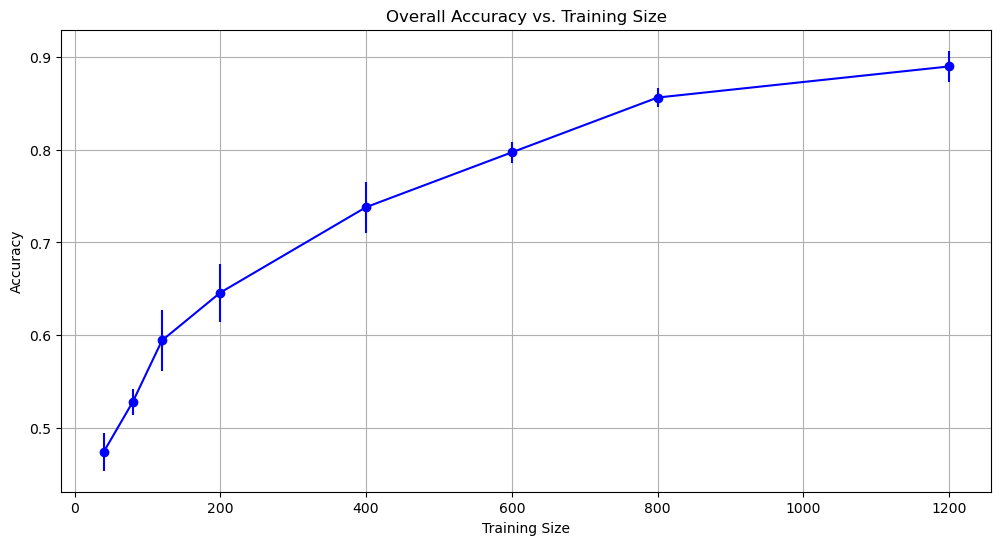

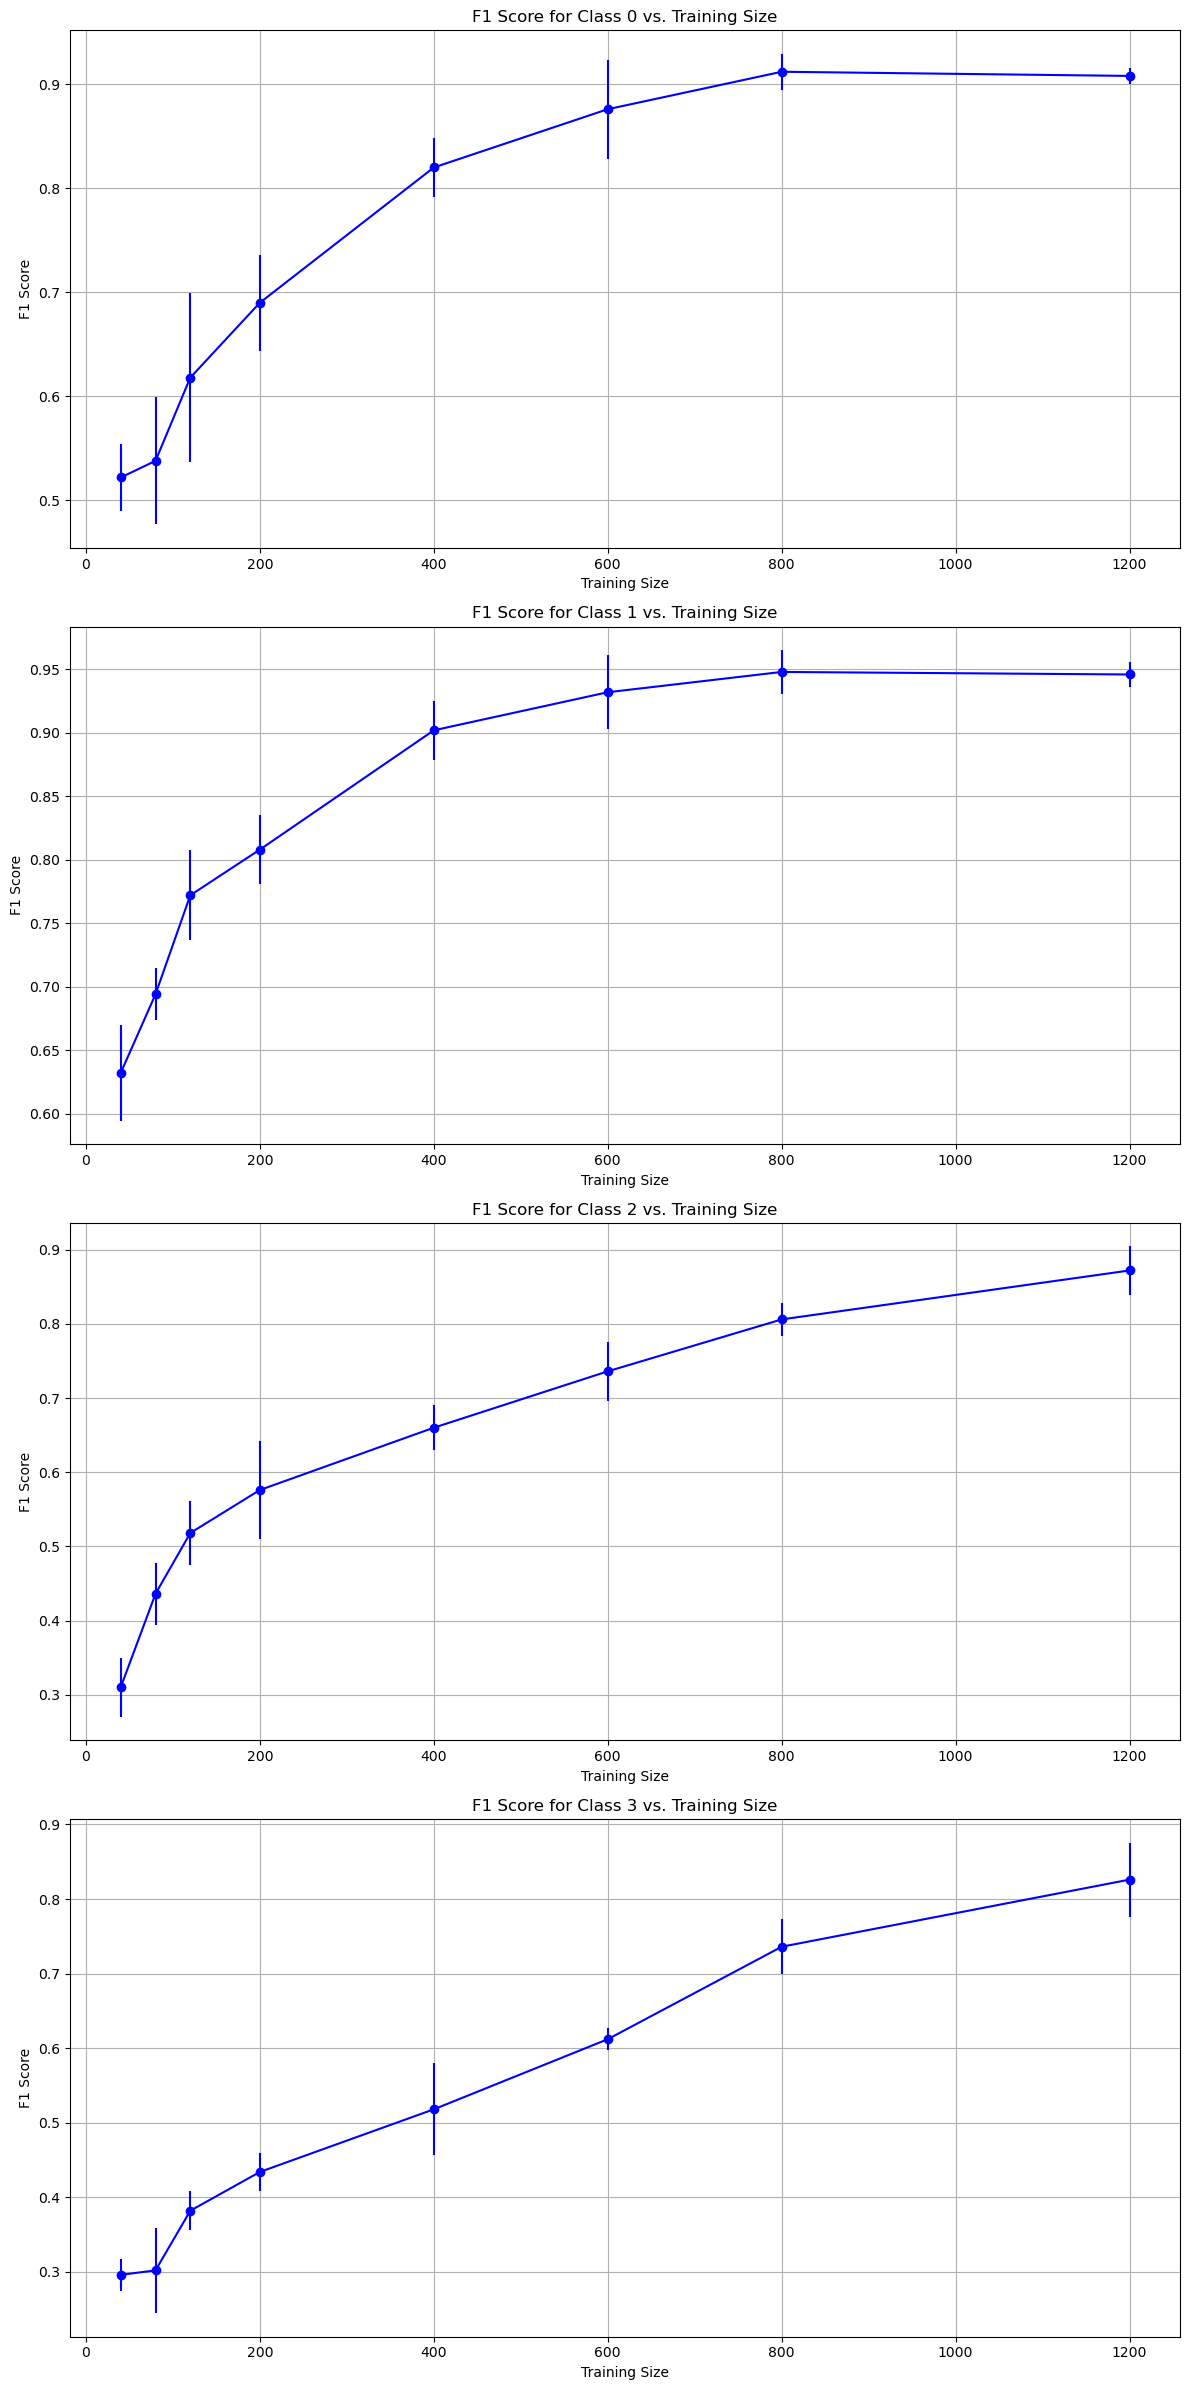

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Define data for experiments
exp_data = {
    1: {
        'training_sizes': [40, 80, 120, 200, 400, 600, 800, 1200],
        'accuracies': [0.4675, 0.5525, 0.6375, 0.6225, 0.7375, 0.7925, 0.8675, 0.9050],
        'f1_scores': [
            [0.53, 0.60, 0.77, 0.64, 0.82, 0.91, 0.91, 0.90],  # Class 0
            [0.62, 0.66, 0.75, 0.84, 0.93, 0.95, 0.95, 0.95],  # Class 1
            [0.29, 0.44, 0.57, 0.52, 0.63, 0.69, 0.82, 0.90],  # Class 2
            [0.27, 0.38, 0.35, 0.40, 0.55, 0.59, 0.78, 0.87]   # Class 3
        ]
    },
    2: {
        'training_sizes': [40, 80, 120, 200, 400, 600, 800, 1200],
        'accuracies': [0.5050, 0.5250, 0.6025, 0.6900, 0.6925, 0.7925, 0.8550, 0.8700],
        'f1_scores': [
            [0.58, 0.59, 0.57, 0.74, 0.78, 0.90, 0.94, 0.91],  # Class 0
            [0.68, 0.71, 0.82, 0.84, 0.87, 0.96, 0.97, 0.94],  # Class 1
            [0.31, 0.41, 0.52, 0.66, 0.64, 0.69, 0.79, 0.84],  # Class 2
            [0.31, 0.25, 0.41, 0.45, 0.40, 0.60, 0.72, 0.77]   # Class 3
        ]
    },
    3: {
        'training_sizes': [40, 80, 120, 200, 400, 600, 800, 1200],
        'accuracies': [0.4425, 0.5225, 0.6150, 0.6050, 0.7325, 0.8000, 0.8375, 0.9100],
        'f1_scores': [
            [0.50, 0.52, 0.63, 0.65, 0.80, 0.86, 0.92, 0.90],  # Class 0
            [0.58, 0.68, 0.81, 0.80, 0.88, 0.92, 0.94, 0.93],  # Class 1
            [0.33, 0.48, 0.53, 0.49, 0.68, 0.76, 0.77, 0.92],  # Class 2
            [0.32, 0.28, 0.40, 0.41, 0.53, 0.62, 0.70, 0.89]   # Class 3
        ]
    },
    4: {
        'training_sizes': [40, 80, 120, 200, 400, 600, 800, 1200],
        'accuracies': [0.4775, 0.5325, 0.5750, 0.6725, 0.7775, 0.8175, 0.8650, 0.8700],
        'f1_scores': [
            [0.51, 0.55, 0.58, 0.75, 0.86, 0.92, 0.90, 0.91],  # Class 0
            [0.61, 0.71, 0.74, 0.78, 0.92, 0.95, 0.96, 0.95],  # Class 1
            [0.37, 0.37, 0.53, 0.64, 0.71, 0.75, 0.82, 0.84],  # Class 2
            [0.27, 0.36, 0.40, 0.44, 0.53, 0.62, 0.70, 0.77]   # Class 3
        ]
    },
    5: {
        'training_sizes': [40, 80, 120, 200, 400, 600, 800, 1200],
        'accuracies': [0.4800, 0.5100, 0.5425, 0.6400, 0.7500, 0.7825, 0.8550, 0.8925],
        'f1_scores': [
            [0.49, 0.43, 0.54, 0.67, 0.84, 0.79, 0.89, 0.92],  # Class 0
            [0.67, 0.71, 0.74, 0.78, 0.91, 0.88, 0.92, 0.96],  # Class 1
            [0.25, 0.48, 0.44, 0.57, 0.64, 0.79, 0.83, 0.86],  # Class 2
            [0.31, 0.24, 0.35, 0.47, 0.58, 0.63, 0.78, 0.83]   # Class 3
        ]
    }
}

# Calculate mean accuracies and F1-scores, and their standard deviations
training_sizes = exp_data[1]['training_sizes']
overall_accuracies = np.array([exp['accuracies'] for exp in exp_data.values()])
mean_accuracies = overall_accuracies.mean(axis=0)
std_accuracies = overall_accuracies.std(axis=0)

f1_scores = np.array([exp['f1_scores'] for exp in exp_data.values()])
mean_f1_scores = f1_scores.mean(axis=0)
std_f1_scores = f1_scores.std(axis=0)

# Plot overall accuracy with error bars
plt.figure(figsize=(12, 6))
plt.errorbar(training_sizes, mean_accuracies, yerr=std_accuracies, fmt='-o', color='blue', label='Mean Accuracy')
plt.title('Overall Accuracy vs. Training Size')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# Plot F1-scores for each class with error bars
fig, axs = plt.subplots(4, 1, figsize=(12, 24))
classes = ['Class 0', 'Class 1', 'Class 2', 'Class 3']
for i in range(4):
    axs[i].errorbar(training_sizes, mean_f1_scores[i], yerr=std_f1_scores[i], fmt='-o', color='blue', label=f'Mean F1 Score - {classes[i]}')
    axs[i].set_title(f'F1 Score for {classes[i]} vs. Training Size')
    axs[i].set_xlabel('Training Size')
    axs[i].set_ylabel('F1 Score')
    axs[i].grid(True)
plt.tight_layout()
plt.show()

In [3]:
mean_accuracies

array([0.4745, 0.5285, 0.5945, 0.646 , 0.738 , 0.797 , 0.856 , 0.8895])

In [4]:
std_accuracies

array([0.02021138, 0.01401785, 0.03291656, 0.0313289 , 0.02758623,
       0.0116619 , 0.01055936, 0.01691153])

In [5]:
mean_f1_scores

array([[0.522, 0.538, 0.618, 0.69 , 0.82 , 0.876, 0.912, 0.908],
       [0.632, 0.694, 0.772, 0.808, 0.902, 0.932, 0.948, 0.946],
       [0.31 , 0.436, 0.518, 0.576, 0.66 , 0.736, 0.806, 0.872],
       [0.296, 0.302, 0.382, 0.434, 0.518, 0.612, 0.736, 0.826]])

In [6]:
std_f1_scores

array([[0.03187475, 0.06112283, 0.0813388 , 0.04604346, 0.02828427,
        0.04758151, 0.01720465, 0.00748331],
       [0.03762978, 0.02059126, 0.03544009, 0.02712932, 0.02315167,
        0.02925748, 0.01720465, 0.01019804],
       [0.04      , 0.04223742, 0.04261455, 0.06590903, 0.0303315 ,
        0.0397995 , 0.02244994, 0.03249615],
       [0.02154066, 0.0574108 , 0.02638181, 0.0257682 , 0.06177378,
        0.01469694, 0.03666061, 0.04963869]])